In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fbprophet import Prophet
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [76]:
df = pd.read_csv("data.txt",  sep=";", parse_dates=[['Date', 'Time']], low_memory=False)
df.head()

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [77]:
df.set_index("Date_Time", inplace=True)
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.0
2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.0
2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.0


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


In [79]:
print( "Rows: ", df.shape[0])
print("Columns: ", df.shape[1])
print("\nFeatures: \n", df.columns.tolist())
print("\nMissing Values: ", df.isnull().any())
print("\nUnique values: ", df.nunique())

Rows:  2075259
Columns:  7

Features: 
 ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

Missing Values:  Global_active_power      False
Global_reactive_power    False
Voltage                  False
Global_intensity         False
Sub_metering_1           False
Sub_metering_2           False
Sub_metering_3            True
dtype: bool

Unique values:  Global_active_power      4187
Global_reactive_power     533
Voltage                  2838
Global_intensity          222
Sub_metering_1             89
Sub_metering_2             82
Sub_metering_3             32
dtype: int64


In [80]:
df.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [81]:
#Let's check for any irregularities not captured by the isna/isnull function
count_na = 0
for values in df.values.tolist():
    for value in values:
        if value == '?':
            count_na += 1
        else:
            continue
#Print the result
print('We have {} missing values not captured by isna/isnull command'.format(count_na))

We have 155874 missing values not captured by isna/isnull command


In [82]:
# replace "?" to NaN
df.replace("?", np.nan, inplace = True)

#Let's recheck with the isna/isnull command
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [114]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [83]:
df_copy = df.interpolate(method='linear', limit_direction='forward')
df_copy.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3               0
dtype: int64

In [84]:
df_copy.fillna(value=0, inplace=True)

In [85]:
df_copy.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [86]:
for column in df_copy.select_dtypes(include=['object']).columns:
    if column != 'Time_Date':
        df_copy[[column]] = df_copy[[column]].astype('float')

In [87]:
df_copy = df_copy.assign(Active_Power=lambda x: ((x['Global_active_power'] * 1000 / 60) - (x['Sub_metering_1'] + x['Sub_metering_2'] + x['Sub_metering_3'])))

In [88]:
df_copy.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Active_Power
Date_Time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [89]:
columns = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Active_Power']
data = df_copy.drop(columns, axis=1)
data.head()

,Global_active_power
Date_Time,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


Text(0, 0.5, 'Active Power')

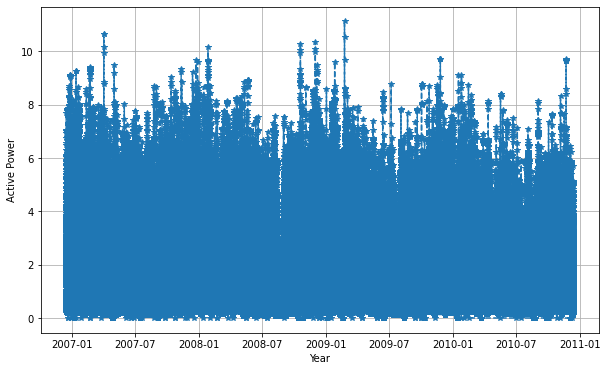

In [90]:
plt.figure(figsize=(10,6))
plt.plot(data.index, data.Global_active_power, '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Active Power')

In [91]:
#Downsample to yearly data points
df_yearly = data.resample('Y').mean()
df_yearly.head()

,Global_active_power
Date_Time,
2006-12-31,1.900949
2007-12-31,1.108653
2008-12-31,1.071822
2009-12-31,1.069854
2010-12-31,1.021624


Text(0, 0.5, 'Global Active Power')

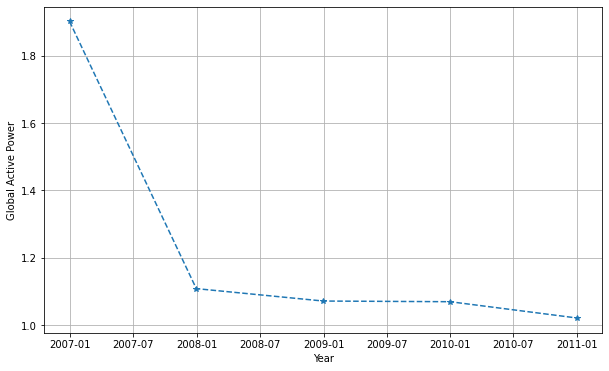

In [92]:
plt.figure(figsize=(10,6))
plt.plot(df_yearly.index, df_yearly.Global_active_power, '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Global Active Power')

In [93]:
#Downsample to 3months data points
df_monthly = data.resample('3M').mean()
df_monthly.head()

,Global_active_power
Date_Time,
2006-12-31,1.900949
2007-03-31,1.278058
2007-06-30,0.950570
2007-09-30,0.931415
2007-12-31,1.276535


Text(0, 0.5, 'Global Active Power')

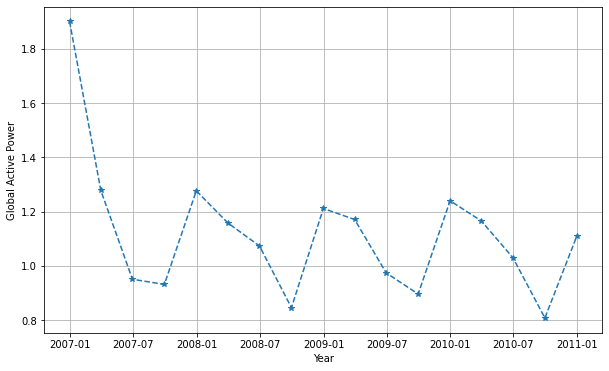

In [94]:
plt.figure(figsize=(10,6))
plt.plot(df_monthly.index, df_monthly.Global_active_power, '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Global Active Power')

In [109]:
#Moving Average

MA = data['Global_active_power'].rolling(1).mean()
MA_SAM = MA.sample(frac=0.3)
MA_SAM

Date_Time
2008-07-03 19:37:00    1.402
2007-05-14 16:26:00    0.566
2009-01-26 14:09:00    1.776
2008-06-01 22:00:00    1.248
2010-05-17 01:16:00    0.918
                       ...  
2009-05-11 08:14:00    1.868
2010-07-07 21:46:00    0.392
2007-01-07 16:56:00    0.290
2008-05-07 14:59:00    1.636
2008-02-22 05:42:00    0.306
Name: Global_active_power, Length: 622578, dtype: float64

In [96]:
#using a sample of 30% of the dataset
df_sample = data.sample(frac=0.3, random_state=0)
df_sample = df_sample.sort_index()
df_sample.head()

,Global_active_power
Date_Time,
2006-12-16 17:24:00,4.216
2006-12-16 17:26:00,5.374
2006-12-16 17:30:00,3.702
2006-12-16 17:31:00,3.700
2006-12-16 17:34:00,4.448


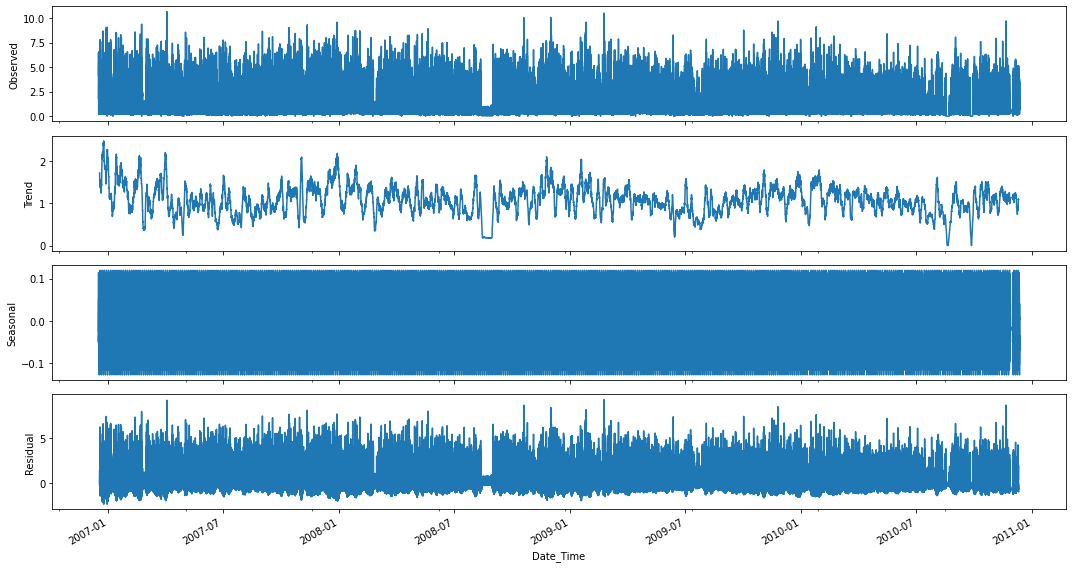

In [97]:
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df_sample['Global_active_power'], model='additive', freq=24*60)
decompose_series.plot()
plt.show()

In [98]:
df_mon.isna().sum()

Global_active_power    37
dtype: int64

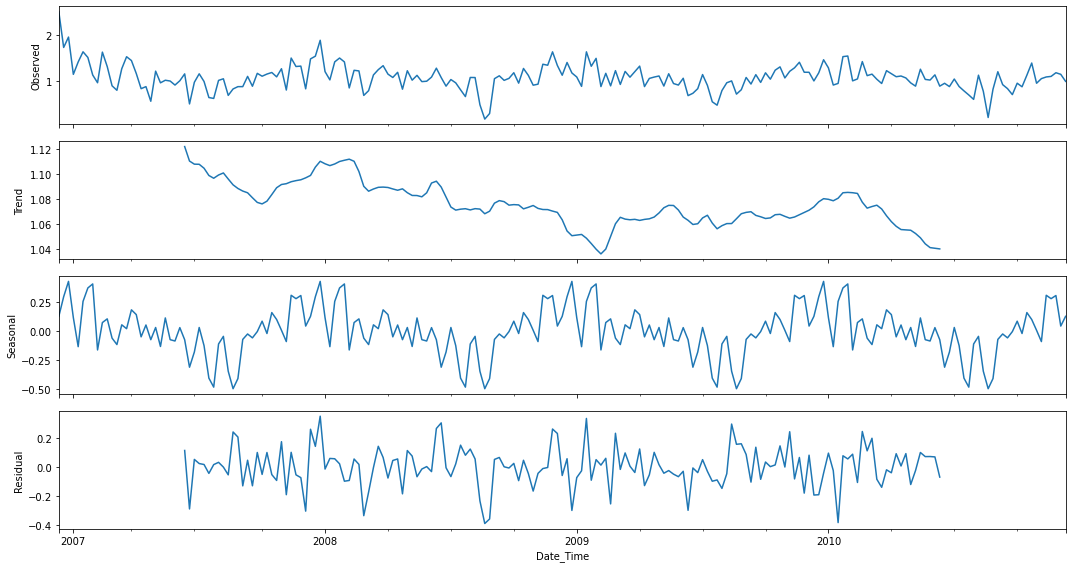

In [99]:
df_mon = data.resample('W').mean()
df_mon.head()


rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df_mon['Global_active_power'], model='additive')
decompose_series.plot()
plt.show()

In [100]:
adf_result = adfuller(df_mon['Global_active_power'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'   {k}: {v}') 

ADF Statistic: -4.410225905367908
p-value: 0.00028470477191040825
No. of lags used: 3
No. of observations used : 205
Critical Values:
   1%: -3.4626576734812318
   5%: -2.8757444215841326
   10%: -2.5743412314098753


In [101]:
df_daily = data.resample('D').mean()
df_daily.head()

,Global_active_power
Date_Time,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


In [102]:
df_daily['Global_active_power'] = df_daily['Global_active_power'].fillna((df_daily['Global_active_power'].mean()))

Text(0, 0.5, 'Power')

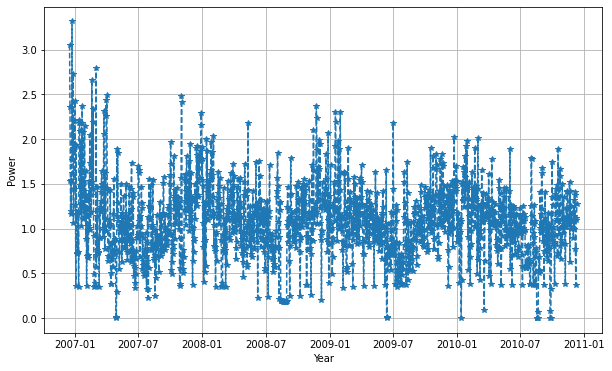

In [103]:
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.Global_active_power, '--', marker='*', )
plt.grid()
plt.xlabel('Year')
plt.ylabel('Power')

In [104]:
df_copy.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Active_Power             0
dtype: int64

In [110]:
df_copy.corr(method='pearson')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Active_Power
Global_active_power,1.000000,0.257542,0.066527,0.998903,0.483442,0.434426,0.633894,0.704199
Global_reactive_power,0.257542,1.000000,0.107710,0.276466,0.124653,0.141190,0.090680,0.226809
Voltage,0.066527,0.107710,1.000000,0.066114,-0.003139,0.004790,-0.015064,0.133259
Global_intensity,0.998903,0.276466,0.066114,1.000000,0.488270,0.440139,0.621952,0.706116
Sub_metering_1,0.483442,0.124653,-0.003139,0.488270,1.000000,0.055201,0.102509,0.126346
Sub_metering_2,0.434426,0.141190,0.004790,0.440139,0.055201,1.000000,0.080965,0.087901
Sub_metering_3,0.633894,0.090680,-0.015064,0.621952,0.102509,0.080965,1.000000,0.171618
Active_Power,0.704199,0.226809,0.133259,0.706116,0.126346,0.087901,0.171618,1.000000


In [116]:
df.corr()

,Sub_metering_3
Sub_metering_3,1.0


In [106]:
len(df_daily)

1457

In [107]:
df_daily['index1'] = df_daily

In [108]:
df_daily.head()

,Global_active_power,index1
Date_Time,,
2006-12-16,3.053475,3.053475
2006-12-17,2.354486,2.354486
2006-12-18,1.530435,1.530435
2006-12-19,1.157079,1.157079
2006-12-20,1.545658,1.545658


In [119]:
from fbprophet import Prophet
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
